In [ ]:
from sklearn.metrics import accuracy_score, classification_report ,precision_score, recall_score, f1_score
import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, auc
from imblearn.over_sampling import SMOTE
from collections import Counter
import xgboost as xgb
import mlflow
import matplotlib.pyplot as plt

In [2]:
health_care = pd.read_csv("cleaned_data_2.csv")
health_care_df = pd.DataFrame(health_care)
health_care_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_category,bmi_category,glucose_category
0,0,0.817073,0,1,1,0,0,0.801265,0.745455,0,1,2,3,4
1,1,0.743902,0,0,1,1,1,0.679023,0.487879,1,1,2,2,4
2,0,0.975610,0,1,1,0,1,0.234512,0.621212,1,1,2,3,3
3,1,0.597561,0,0,1,0,0,0.536008,0.678788,2,1,1,3,2
4,1,0.963415,1,0,1,1,1,0.549349,0.363636,1,1,2,1,2


In [3]:
print("Data Shape:", health_care_df.shape)
print("\nMissing Values:", health_care_df.isnull().sum().max())
print("\nClass Distribution:\n", health_care_df['stroke'].value_counts(normalize=True))

Data Shape: (5110, 14)

Missing Values: 0

Class Distribution:
 stroke
0    0.951272
1    0.048728
Name: proportion, dtype: float64


In [4]:
X = health_care_df.drop(['stroke'], axis=1)
y = health_care_df['stroke']

In [5]:
smote = SMOTE(sampling_strategy=0.7,random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)
print("After SMOTE:", Counter(y_smote))

After SMOTE: Counter({0: 4861, 1: 3402})


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, stratify=y_smote, random_state=42)

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Class distribution in training:", Counter(y_train))

Class distribution in training: Counter({0: 3889, 1: 2721})


# <span style="color:green">Loading our model</span>

In [8]:
xg_model = joblib.load("xgboost_model.pkl")

In [9]:
xg_model.fit(X_train_scaled, y_train)
y_pred = xg_model.predict(X_test_scaled)
y_proba = xg_model.predict_proba(X_test_scaled)[:,1]
acc = accuracy_score(y_test, y_pred)

In [10]:
print("\nClassification Report For Logistic Regression :")
print(classification_report(y_test, y_pred))
print("\nAUC-ROC For Logistic Regression :", roc_auc_score(y_test, y_proba))


Classification Report For Logistic Regression :
              precision    recall  f1-score   support

           0       0.97      0.89      0.93       972
           1       0.86      0.96      0.91       681

    accuracy                           0.92      1653
   macro avg       0.91      0.92      0.92      1653
weighted avg       0.92      0.92      0.92      1653


AUC-ROC For Logistic Regression : 0.978547645377471


# <span style="color:green"> MLOps with MLflow
</span>

In [11]:
mlflow.set_experiment("Stroke-Prediction-XGBoost")    

2025/05/11 11:12:49 INFO mlflow.tracking.fluent: Experiment with name 'Stroke-Prediction-XGBoost' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///d:/CODING/DEPI/Depi%20final%20project/mlruns/353621282367085112', creation_time=1746951169860, experiment_id='353621282367085112', last_update_time=1746951169860, lifecycle_stage='active', name='Stroke-Prediction-XGBoost', tags={}>

In [12]:
if mlflow.active_run():
    mlflow.end_run()
with mlflow.start_run():
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)

d:\myenv\lib\site-packages\xgboost\training.py:183: UserWarning: [11:12:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [13]:
preds = model.predict(X_test)
acc = accuracy_score(y_test, preds)

In [14]:
mlflow.log_param("model_type", "XGBoost")

'XGBoost'

# <span style="color:green"> Logging the metrics of our model
</span>

In [15]:

mlflow.log_metric("accuracy", acc)
mlflow.log_metric("accuracy", accuracy_score(y_test, y_pred))
mlflow.log_metric("precision", precision_score(y_test, y_pred))
mlflow.log_metric("recall", recall_score(y_test, y_pred))
mlflow.log_metric("f1_score", f1_score(y_test, y_pred))
mlflow.log_metric("roc_auc", roc_auc_score(y_test, y_proba))

In [16]:
mlflow.xgboost.log_model(model, artifact_path="xgb_model")
print(f"Logged XGBoost model with accuracy: {acc:.4f}")

d:\myenv\lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [11:12:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/05/11 11:13:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged XGBoost model with accuracy: 0.9341


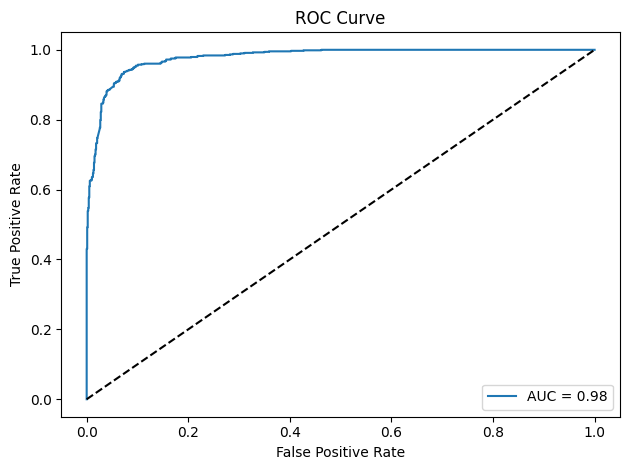

In [17]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("roc_curve.png")
mlflow.log_artifact("roc_curve.png")